## Investigating the relationship between total freeboard and ice draft

#### using airborne LiDAR for total freeboard, and AUV observations for draft

Adam Steer, adam.d.steer@gmail.com

### Rationale:
The first aim is to look at how LiDAR-derived ice draft is different from in situ draft. It is unrealistic toexpect that the two surfaces will match exactly, but knowing how they differ will guide what is possible for further analysis of altimetry-derived ice draft at high resolutions. For example, can we assume that things like turbulent heat flux can be modelled correctly based on ice/ocean interface features using ice draft derived from altimetry?

The second aim looks at the relationship between total freeboard and ice draft. Research on deriving ice draft (or ice thickness) from total freeboard is full of efforts to extract a scalar ratio *R* which relates surface topography (total freeboard) to the ice/ocean interface (draft).

Analysis of in situ observations from drill holes found that these two surfaces are very weakly related - so it is hard to see how *R* is a great predictor of ice draft.

In this notebook, total freeboard and draft datasets are gridded to a common resolution, and the resulting data are analysed to pick apart relationships between the two surfaces. A basic segmentation of smooth and rough ice is also performed, and smooth/rough ice regions analysed separately.

In [5]:
#setting up...
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import linear_model
from scipy import stats

In [6]:
import pandas as pd

### Get AUV data

In [7]:
uav = np.genfromtxt('../../PhD/python-phd/guy_auv/is6_50cm_auv_draft_sipexgrid.txt')

In [8]:
uav[0]

array([ 179.71 ,  -57.282,      nan,      nan])

In [9]:
uav = uav[:,0:3]

In [10]:
uav.shape

(478130, 3)

In [11]:
uav_subset = uav[(uav[:,0] >= -150) & (uav[:,0] <= 130) & (uav[:,1] >= -30) & (uav[:,1] <= 275) ]
#uav_subset[:,0] = uav_subset[:,0] - min(uav_subset[:,0])
#uav_subset[:,1] = uav_subset[:,1] - min(uav_subset[:,1])

(-200.0, 150.0, -50.0, 300.0)

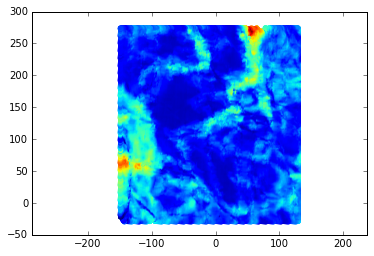

In [12]:
plt.scatter(uav_subset[:,0], uav_subset[:,1], c=uav_subset[:,2], lw=0)
plt.axis('equal')

### Get LiDAR data

In [14]:
lidar= np.genfromtxt('../../PhD/is6_f11/python_zi/is6_f11_pass1_aa_nr2_522816_523019_crproxy.xyz', skip_header=1)

### Extract a subset matching the AUV drafts

In [15]:
lidar_subset = lidar[(lidar[:,1] >= -150) & (lidar[:,1] <= 130) & (lidar[:,2] >= -30) & (lidar[:,2] <= 275) ]
#lidar_subset[:,1] = lidar_subset[:,1] - min(lidar_subset[:,1])
#lidar_subset[:,2] = lidar_subset[:,2] - min(lidar_subset[:,2])
lidar_subset

array([[  5.22939098e+05,   1.29927000e+02,  -2.99270000e+01,
          1.06658000e+00,   1.09222000e+00,   1.67520000e-01],
       [  5.22939128e+05,   1.20266000e+02,  -2.98850000e+01,
          1.06675000e+00,   1.10236000e+00,   1.83940000e-01],
       [  5.22939128e+05,   1.21398000e+02,  -2.97590000e+01,
          1.11885000e+00,   1.15548000e+00,   1.53200000e-01],
       ..., 
       [  5.22945798e+05,  -1.39965000e+02,   2.74667000e+02,
          6.89910000e-01,   6.82630000e-01,   8.91400000e-02],
       [  5.22945798e+05,  -1.38739000e+02,   2.74861000e+02,
          7.14420000e-01,   7.15380000e-01,   1.00030000e-01],
       [  5.22945828e+05,  -1.49699000e+02,   2.74947000e+02,
          7.12570000e-01,   7.03560000e-01,   6.40500000e-02]])

(-200.0, 150.0, -50.0, 300.0)

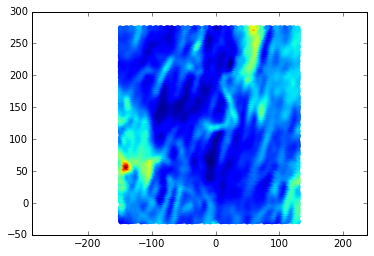

In [16]:
plt.scatter(lidar_subset[:,1], lidar_subset[:,2], c=lidar_subset[:,3], lw=0)
plt.axis('equal')

### Estimate some ice thickness, and then draft

In [17]:
from compute_zi_functions import compute_zi, compute_zs

In [18]:
d_snow = 326.31
#d_snow = 305.67 #mean of all EA obs
sd_dsnow = 10
d_ice = 915.6 #empirically derived from matching with AUV draft
sd_dice = 10
d_water = 1028 #Hutchings2015
sd_dwater = 1

#sipex2 snow model
s_i = ([0.701, -0.0012])

zs, zs_uncert = compute_zs(lidar_subset[:,3], s_i, 0.1)

zi, zi_uncert = compute_zi(lidar_subset[:,3], zs, d_ice, d_water, d_snow, 0.1,
                           zs_uncert, sd_dsnow, sd_dice, sd_dwater)

lidar_draft =np.abs(lidar_subset[:,3] - (zs + zi))

### Grid the AUV and LiDAR data, to 1m spatial resolution

In [19]:
from scipy.interpolate import griddata

In [20]:
grid_x = np.arange(np.floor(min(lidar_subset[:,1])),np.ceil(max(lidar_subset[:,1])+1), 1.0)
grid_y = np.arange(np.floor(min(lidar_subset[:,2])),np.ceil(max(lidar_subset[:,2])+1), 1.0)

#grid_x = np.arange(0,np.ceil(max(lidar_subset[:,0]))-np.floor(min(lidar_subset[:,0])), 0.5)
#grid_y = np.arange(0,np.ceil(max(lidar_subset[:,1]))-np.floor(min(lidar_subset[:,1])), 0.5)

xx, yy = np.meshgrid(grid_x, grid_y)
np.min(yy)
np.max(yy)

275.0

In [21]:
#from matplotlib.mlab import griddata as gd

#g_lidar = gd(lidar_subset[:,1], lidar_subset[:,2], lidar_draft, grid_x,grid_y, interp='linear')
#g_elev = gd(lidar_subset[:,1], lidar_subset[:,2], lidar_subset[:,3], grid_x,grid_y, interp='linear')

g_lidar = griddata(lidar_subset[:,1:3], lidar_draft, (xx, yy), method='nearest')
g_elev = griddata(lidar_subset[:,1:3], lidar_subset[:,3], (xx, yy), method='nearest')


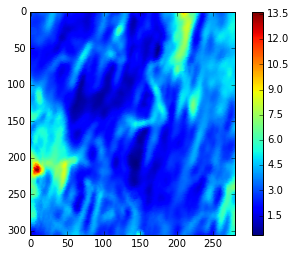

In [22]:
plt.imshow(g_lidar[::-1])
plt.colorbar()

In [23]:
uav_subset = uav_subset[~np.isnan(uav_subset).any(1)]

In [24]:
len(uav_subset[:,2])

338334

In [25]:
uav_subset[:,2]

array([ 5.2392,  5.3583,  5.2709, ...,  3.1457,  3.0108,  2.8692])

In [26]:
np.min(uav_subset[:,1])

-29.998999999999999

In [27]:
np.min(grid_y)

-30.0

In [28]:
g_auv = griddata(uav_subset[:,0:2], uav_subset[:,2], (xx, yy), method='nearest')
#g_auv = gd(uav_subset[:,0], uav_subset[:,1], uav_subset[:,2], grid_x, grid_y, interp='linear')

g_lidar = g_lidar[::-1]
g_auv = g_auv[::-1]
g_elev = g_elev[::-1]

### A quick sanity check - are we looking at similar draft numbers from each dataset?

In [29]:
print('mean AUV draft: {}, mean liDAR draft: {}'.format(np.mean(g_auv), np.mean(g_lidar)))

mean AUV draft: 3.285409869220687, mean liDAR draft: 3.2626971841859045


In [30]:
print('std AUV draft: {}, std liDAR draft: {}'.format(np.std(g_auv), np.std(g_lidar)))

std AUV draft: 2.001057163362628, std liDAR draft: 1.4096182963174801


#### OK, not quite matching but well within 1-sigma.

## Plotting the two grids for an eyeball comparison

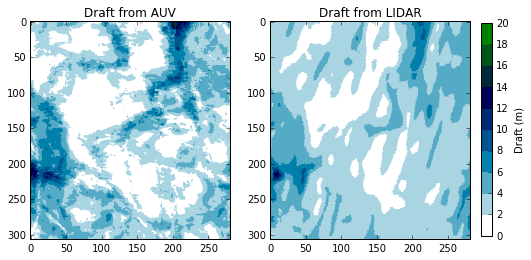

In [31]:
import matplotlib as mpl
cmap = mpl.cm.cool
norm = mpl.colors.Normalize(vmin=0, vmax=20)

cmap = plt.get_cmap('ocean_r', 10)

fig = plt.figure(figsize = ([20/2.54, 10/2.54]), dpi=300)

ax0 = fig.add_subplot(121)
g0 = ax0.imshow(g_auv, cmap=cmap, vmin=0, vmax=20)
ax0.set_title('Draft from AUV')

#cbaxes0 = fig.add_axes([0.48, 0.14, 0.02, 0.75]) 
#cb0 = plt.colorbar(g0, cax=cbaxes0, cmap=cmap)
#cb0.ax.set_ylabel('Draft (m)', rotation=90)


ax1 = fig.add_subplot(122)
g1 = ax1.imshow(g_lidar, cmap=cmap, vmin=0, vmax=20)
ax1.set_title('Draft from LIDAR')

cbaxes1 = fig.add_axes([0.92, 0.14, 0.02, 0.75]) 
cb1 = plt.colorbar(g1, cax=cbaxes1, cmap=cmap)
cb1.ax.set_ylabel('Draft (m)', rotation=90)



## Two datasets on a common grid - what are the differences?

### difference map

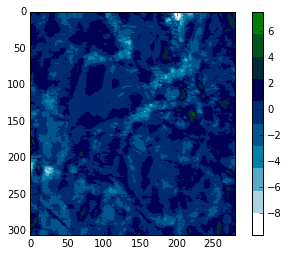

In [32]:
cmap = plt.get_cmap('ocean_r', 10)
norm = mpl.colors.Normalize(vmin=-10, vmax=10)

plt.imshow(g_lidar - g_auv, cmap=cmap)
plt.colorbar(cmap=cmap)

This is quite interesting. At about [10, 80] (grid coords) there's a peaky ridge which was split by a crack. Here, the LiDAR draft 'peak'is offset a little from the AUV - it's basically captured the leftmoast (grid view) peak but not the part on the right side of the crack. So there are large differences each side of the narrow ridge picked on by LiDAR. This pattern is going to be seen a lot - it's clear (and well known) that keel systems are often wider than ridges.

The ridge/keel system roughly along X=[150 -> 200] is better represented, but still narrower (and less deep) in the LiDAR-based model. The keel system between X=[100 -> 150] and y = [250 -> 300] is really not seen at all in the LiDAR based model, although it's still significant (to 6m deep!)

## Normalising the data to see if interpretation is any easier

short answer: no.

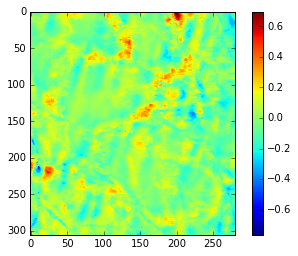

In [33]:
g2_auv = g_auv-np.mean(g_auv)
g2_lidar = g_lidar-np.mean(g_lidar)
plt.imshow(g2_auv/np.max(g2_auv) - g2_lidar/np.max(g2_lidar))
plt.colorbar()

### let's put all that into one figure:

[ -50.    0.   50.  100.  150.  200.  250.  300.  350.]


/Users/arcturus/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


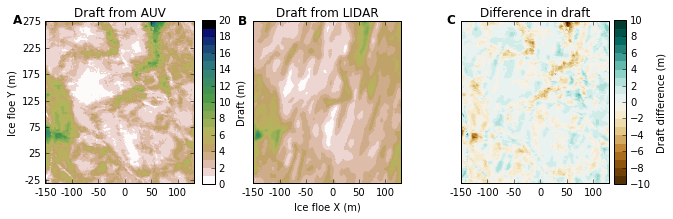

In [34]:
cmap = plt.get_cmap('gist_earth_r', 20)


ytks = np.arange(-25,300,50)
ytk_l = np.arange(-25,375,50)
xtks = np.arange(-200,150,50)

fig = plt.figure(figsize = ([22/2.54, 10/2.54]), dpi=300)

ax0 = fig.add_subplot(131)
g0 = ax0.imshow(g_auv, cmap=cmap, vmin=0, vmax=20.1)
ax0.set_title('Draft from AUV')
ax0.set_ylabel('Ice floe Y (m)')
ax0.text(-0.19, 1.01,'A', ha='center', va='center', transform=ax0.transAxes, fontsize=12, weight='bold')
#ax0.set_yticks(ytks[::-1])
#ax0.set_xlim([-150,130])
#ax0.set_ylim([-30,275])
ax0.set_xticklabels(xtks)

this = ax0.get_yticks()
print(this)
ax0.set_yticklabels(ytk_l[::-1])

ax1 = fig.add_subplot(132)
g1 = ax1.imshow(g_lidar, cmap=cmap, vmin=0, vmax=20)
ax1.set_title('Draft from LIDAR')
ax1.set_xlabel('Ice floe X (m)')
#ax1.set_xlim([-150,130])
#ax1.set_ylim([-30,275])
cbaxes1 = fig.add_axes([0.33, 0.21, 0.02, 0.58]) 
cb1 = plt.colorbar(g1, cax=cbaxes1, cmap=cmap)
cb1.ax.set_ylabel('Draft (m)', rotation=90)
ax1.set_yticks([])
ax1.set_xticklabels(xtks)
ax1.text(-0.07, 1.005,'B', ha='center', va='center', transform=ax1.transAxes, fontsize=12, weight='bold')

cmap = plt.get_cmap('BrBG', 20)

diff = g_lidar-g_auv

ax2 = fig.add_subplot(133)
ax2.set_yticks([])
g2 = ax2.imshow(diff, cmap=cmap, vmin=-10, vmax=10)
ax2.set_title('Difference in draft')
cbaxes2 = fig.add_axes([0.99, 0.21, 0.02, 0.58]) 
cb2 = plt.colorbar(g2, cax=cbaxes2, cmap=cmap)
cb2.ax.set_ylabel('Draft difference (m)', rotation=90)
ax2.set_yticks([])
ax2.set_xticklabels(xtks)
ax2.text(-0.07, 1.01,'C', ha='center', va='center', transform=ax2.transAxes, fontsize=12, weight='bold')


plt.tight_layout()
fig.subplots_adjust(wspace=0.4)


plt.savefig('draft_diffs_11m.pdf', bbox_inches='tight')

### Another new thesis figure is born!
In panel C here, 'blue' means that LiDAR-derived draft is deeper than AUV draft, and 'brown' means that AUV draft is deeper than LiDAR-derived draft. We pretty much see the snow dune pattern reflected here - pretty linear features where LiDAR draft is deeper. We also see the well documented 'keels are wider than ridges' feature. Ridge *peaks* provide deep, pointy, narrow keels from LiDAR - but AUV draft obs reveal broader keels. 

## And then let's do some simple maths.
- what is the correlation between draft(AUV) and draft(LIDAR)
- what is the correlation between surface(LIDAR) and draft(AUV)
- what is the correlation between surface(LIDAR) and draft(LiDAR)

Spearman's non parametric *R* is used because Doble et al. 2011 rightly avoid the presumption of an underlying normal distribution of total freeboard or draft observations.

In [35]:
import pandas as pd

arr_s = np.shape(g_lidar)

g_l_1d = np.reshape(g_lidar, (arr_s[0]*arr_s[1],1))
g_a_1d = np.reshape(g_auv, (arr_s[0]*arr_s[1],1))
g_e_1d = np.reshape(g_elev, (arr_s[0]*arr_s[1],1))

keepthis = np.where(~np.isnan(g_l_1d))

g_l_1d = g_l_1d[keepthis]
g_a_1d = g_a_1d[keepthis]
g_e_1d = g_e_1d[keepthis]

df2 = pd.DataFrame(g_l_1d,columns=['d_l'])
df2['d_a'] = g_a_1d
df2['e'] = g_e_1d

#nonparametric spearman's R
sprmn_r_ld_ad = df2['d_l'].corr(df2['d_a'], method='spearman')
sprmn_r_e_ad = df2['e'].corr(df2['d_a'], method='spearman')
sprmn_r_e_ld = df2['e'].corr(df2['d_l'], method='spearman')


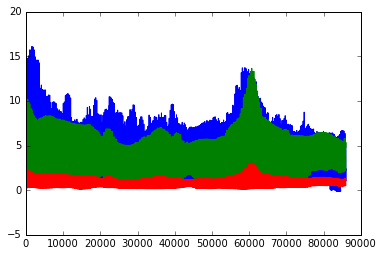

In [36]:
plt.plot(g_a_1d)
plt.plot(g_l_1d)
plt.plot(g_e_1d)

In [37]:
print('Spearmans R for LiDAR draft -> AUV draft: {}, LiDAR elevation -> AUV draft: {},\
       and LiDAR elevation to LiDAR draft: {}'.format(sprmn_r_ld_ad, sprmn_r_e_ad, sprmn_r_e_ld))

Spearmans R for LiDAR draft -> AUV draft: 0.739367300498805, LiDAR elevation -> AUV draft: 0.739367300498805,       and LiDAR elevation to LiDAR draft: 1.0


LiDAR and AUV draft are strongly correlated at **0.73** which is a win. 

**Total freeboard and draft are strongly correlated, at *0.73*.** What's the correlation between draft and topography from SIPEX-II IS6? Better check...

In [38]:
is6holes = np.genfromtxt('/Users/arcturus/Documents/PhD/is6_f11/auv_lidar/is6.csv', delimiter = ',')
is6zs = is6holes[:,4]
is6tf = is6holes[:,3] + is6holes[:,4]
is6fi = is6holes[:,3]
is6draft = is6holes[:,5]

this = np.where(~np.isnan(is6draft))

df3 = pd.DataFrame(is6draft[this], columns=['draft'])
df3['tf'] = is6tf[this]
df3['zs'] = is6zs[this]
sprmn_r_tf_d = df3['tf'].corr(df3['draft'], method='spearman')
print('Spearmans R for in situ total freeboard and draft: {}'.format(sprmn_r_tf_d))

Spearmans R for in situ total freeboard and draft: -0.30206503700803733


In [39]:
sprmn_r_tf_d = df3['tf'].corr(df3['zs'], method='spearman')
print('Spearmans R for in situ total freeboard and snow depth: {}'.format(sprmn_r_tf_d))

Spearmans R for in situ total freeboard and snow depth: 0.8346499889820734


### So this is pretty good news for an R value

**0.67** is a pretty good indication that there's some value in deriving draft straight from total freeboard. Lets have a look at the data. A good old scatter plot!

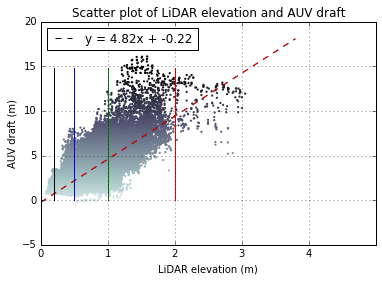

In [40]:
y_ax = np.arange(0,15,0.2)
x_ax = np.arange(0,4,0.2)
line1 = np.zeros_like(y_ax)
line1[:] = 0.2
line2 = np.ones_like(y_ax)
line2[:] = 0.5
line3 = np.ones_like(y_ax)
line3[:] = 1.0
line4 = np.ones_like(y_ax)
line4[:] = 2.0

fit = np.polyfit(g_e_1d,g_a_1d,1)
fit_fn = np.poly1d(fit)
f_s,f_i = np.polyfit(g_e_1d,g_a_1d,1)

f_sr, f_ir, r_, p_, std_e = stats.linregress(g_e_1d, g_a_1d)



plt.scatter(g_e_1d, g_a_1d, lw=0, s=5, c=g_a_1d, cmap='bone_r', vmin=-2, vmax=15)
plt.plot(x_ax,fit_fn(x_ax), 'k--', label = 'y = {:02.2f}x + {:02.2f}'.format(f_s, f_i))
plt.plot(x_ax,(x_ax*f_sr) + f_ir, 'r--')

plt.ylabel('AUV draft (m)')
plt.xlabel('LiDAR elevation (m)')
plt.plot(line1,y_ax, 'k')
plt.plot(line2,y_ax, 'b')
plt.plot(line3,y_ax, 'g')
plt.plot(line4,y_ax, 'r')

plt.grid()
plt.xlim([0, 5])
the_xtix = np.arange(0,5,1)
plt.xticks(the_xtix)
#plt.axis('equal')
plt.title('Scatter plot of LiDAR elevation and AUV draft')
plt.legend(loc=0)
#plt.tight_layout()


plt.savefig('ch4_elevation_v_draft_11m.pdf', bbox_inches='tight')
plt.savefig('ch4_elevation_v_draft_11m.png', bbox_inches='tight')

This plot shows a pretty interesting distribution! But, as we can see from the four vertical lines, we have many choices of draft for a given elevation.

So what is going on here? Why such a big range? For a given total freeboard, there is a variable snow component, and a variably-dense sea ice component in it's corresponding draft observation. 

In [41]:
print('slope: {}, intercept: {}'.format(f_s, f_i))

slope: 4.816503678183385, intercept: -0.2228681449743827


But a mean ratio of draft to elevation ratio (a proper *R*) for these data is higher:

In [42]:
np.mean(g_a_1d/g_e_1d)

4.5094647943754804

## Segmenting by roughness

What are useful analyses here. I'm not sure. There are not enough data to say anything really. There are two ridge systems reasonable well represented, so I could look at relative area of 'smooth' ice for the top surfaces in 3D. Surely there is literature about it from drill holes too. But what will we find here? Probably the same as Doble et al. (2011), or reinforcing ch2's finding that it's not all that precise.

There is already built a proxy for roughness - standard deviation of 11m diameter neighbourhooods about each point. So that's a good start point.

In [43]:
#call in a premade roughness proxy..
r= np.genfromtxt('../../PhD/is6_f11/python_zi/is6_f11_pass1_aa_nr2_522816_523019_crproxy.xyz', skip_header=1)

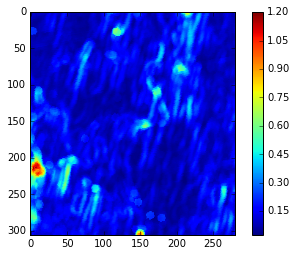

In [44]:
#subset the data
r_subset = r[(r[:,1] >= -150) & (r[:,1] <= 130) & (r[:,2] >= -30) & (r[:,2] <= 275) ]
#r_subset[:,1] = r_subset[:,1] - min(r_subset[:,1])
#r_subset[:,2] = r_subset[:,2] - min(r_subset[:,2])

#grid the data

g_rproxy = griddata(r_subset[:,1:3], r_subset[:,5], (xx, yy), method='nearest')

g_rproxy = g_rproxy[::-1]

#g_rproxy = gd(r_subset[:,1], r_subset[:,2], r_subset[:,5], grid_x,grid_y, interp='linear')

g_rproxy_1d = np.reshape(g_rproxy, (arr_s[0]*arr_s[1],1))
g_rproxy_1d = g_rproxy_1d[keepthis]



plt.imshow(g_rproxy)
plt.colorbar()

In [45]:
rough = np.where(g_rproxy_1d > np.nanmean(g_rproxy_1d))
smooth = np.where(g_rproxy_1d <= np.nanmean(g_rproxy_1d))

rgh_g = np.where(g_rproxy > np.nanmean(g_rproxy))
smth_g = np.where(g_rproxy <= np.nanmean(g_rproxy))

In [46]:
print("mean rough ice draft (AUV): {} ({}), mean smooth ice draft (AUV): {} ({})".format(np.mean(g_a_1d[rough]),
                                                                                         np.std(g_a_1d[rough]),
                                                                                         np.mean(g_a_1d[smooth]),
                                                                                         np.std(g_a_1d[smooth])))

mean rough ice draft (AUV): 4.221539212549349 (2.312383417609072), mean smooth ice draft (AUV): 2.7748718680469437 (1.591627793582069)


In [47]:
print("mean rough ice TF: {} ({}), mean smooth ice TF: {} ({})".format(np.mean(g_e_1d[rough]),
                                                                       np.std(g_e_1d[rough]),
                                                                       np.mean(g_e_1d[smooth]),
                                                                       np.std(g_e_1d[smooth])))

mean rough ice TF: 0.888409538638985 (0.34386031575996207), mean smooth ice TF: 0.6411151043295412 (0.25993462851259463)


### setting up all done.
Lets plot some rough and smooth ice regions

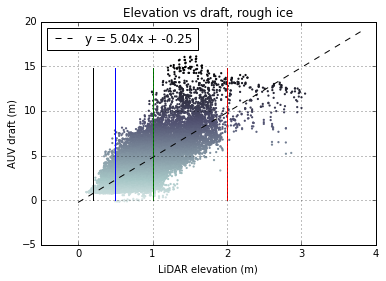

In [48]:
rfit = np.polyfit(g_e_1d[rough],g_a_1d[rough],1)
rfit_fn = np.poly1d(rfit)

x_ax = np.arange(0,4,0.2)
rf_s,rf_i = np.polyfit(g_e_1d[rough],g_a_1d[rough],1)

plt.scatter(g_e_1d[rough], g_a_1d[rough], lw=0, s=5, c=g_a_1d[rough], cmap='bone_r', vmin=-2, vmax=15)
plt.plot(x_ax, rfit_fn(x_ax), 'k--', label = 'y = {:02.2f}x + {:02.2f}'.format(rf_s, rf_i) )
plt.ylabel('AUV draft (m)')
plt.xlabel('LiDAR elevation (m)')
plt.plot(line1,y_ax, 'k')
plt.plot(line2,y_ax, 'b')
plt.plot(line3,y_ax, 'g')
plt.plot(line4,y_ax, 'r')
plt.title('Elevation vs draft, rough ice')
plt.grid()
#plt.xlim([-2, 17])
the_xtix = np.arange(0,5,1)
plt.xticks(the_xtix)
plt.legend(loc=0)
#plt.axis('equal')
plt.savefig('ch4_elevation_v_draft_rgh_11m.pdf', bbox_inches='tight')
plt.savefig('ch4_elevation_v_draft_rgh_11m.png', bbox_inches='tight')


In [49]:
print('slope: {}, intercept: {}'.format(rf_s, rf_i))

slope: 5.037827518022695, intercept: -0.2541148084799701


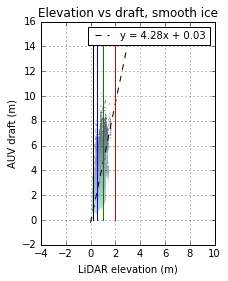

In [50]:
sfit = np.polyfit(g_e_1d[smooth],g_a_1d[smooth],1)
sfit_fn = np.poly1d(fit)

sf_s,sf_i = np.polyfit(g_e_1d[smooth],g_a_1d[smooth],1)


plt.scatter(g_e_1d[smooth], g_a_1d[smooth], lw=0, s=0.5, c=g_a_1d[smooth], cmap='bone_r', vmin=-2, vmax=15)
plt.plot(x_ax, sfit_fn(x_ax), 'k--', label = 'y = {:02.2f}x + {:02.2f}'.format(sf_s, sf_i) )
plt.ylabel('AUV draft (m)')
plt.xlabel('LiDAR elevation (m)')
plt.plot(line1,y_ax, 'k')
plt.plot(line2,y_ax, 'b')
plt.plot(line3,y_ax, 'g')
plt.plot(line4,y_ax, 'r')
plt.title('Elevation vs draft, smooth ice')
plt.grid()
plt.axis('scaled')
#the_xtix = np.arange(-10,20,2)
#plt.xticks(the_xtix)
#plt.yticks(the_xtix)
plt.xlim([-4, 10])
plt.ylim([-2, 16])
plt.legend(loc=1, fontsize=10)

plt.savefig('ch4_elevation_v_draft_smth_11m.pdf', bbox_inches='tight')
plt.savefig('ch4_elevation_v_draft_smth_11m.png', bbox_inches='tight')

In [51]:
print('slope: {}, intercept: {}'.format(sf_s, sf_i))

slope: 4.275162303429539, intercept: 0.03400074185798901


### so far:

- rough and smooth ice both have similar linear fits, with slopes near *R* (close to 4)
- rough ice is found at all LiDAR elevations
- smooth ice is in the lower proportion (below 2m freeboard)
- for most of the elevation range, there are a wide range of possible draft choices

Next - any relationship changes?

In [52]:
df_smth = pd.DataFrame(g_e_1d[smooth],columns=['tf'])
df_smth['d_a'] = g_a_1d[smooth]

In [53]:
sprmn_r_tf_d_smth = df_smth.tf.corr(df_smth.d_a, method='spearman')
print('Spearmans R for in situ total freeboard and draft, smooth ice: {}'.format(sprmn_r_tf_d_smth))

Spearmans R for in situ total freeboard and draft, smooth ice: 0.7099639127148444


In [54]:
df_rgh = pd.DataFrame(g_e_1d[rough],columns=['tf'])
df_rgh['d_a'] = g_a_1d[rough]

In [55]:
sprmn_r_tf_d_rgh = df_rgh.tf.corr(df_rgh.d_a, method='spearman')
print('Spearmans R for in situ total freeboard and draft, rough ice: {}'.format(sprmn_r_tf_d_rgh))

Spearmans R for in situ total freeboard and draft, rough ice: 0.7211732041461045


...pretty much not. Still a strong correlation, but we've just seen the caveats coming with that.

Next - what does AUV draft look like under smooth or rough ice?

In [56]:
g_l_r = griddata(uav_subset[:,0:2], uav_subset[:,2], (xx, yy), method='nearest')
g_l_r = g_l_r[::-1]
g_l_r[smth_g]=-1

g_l_s = griddata(uav_subset[:,0:2], uav_subset[:,2], (xx, yy), method='nearest')
g_l_s = g_l_s[::-1]
g_l_s[rgh_g]=-1


g_e_r = griddata(lidar_subset[:,1:3], lidar_subset[:,3], (xx, yy), method='nearest')
g_e_r = g_e_r[::-1]
g_e_r[smth_g]=-1

g_e_s = griddata(lidar_subset[:,1:3], lidar_subset[:,3], (xx, yy), method='nearest')
g_e_s = g_e_s[::-1]
g_e_s[rgh_g]=-1


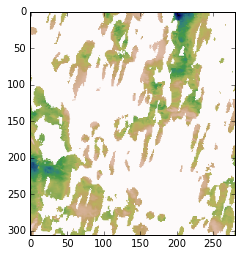

In [57]:
plt.imshow(g_l_r, cmap='gist_earth_r')

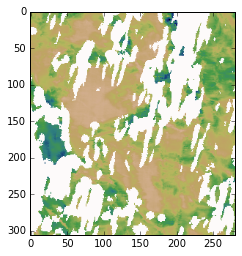

In [58]:
plt.imshow(g_l_s,  cmap='gist_earth_r')

/Users/arcturus/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


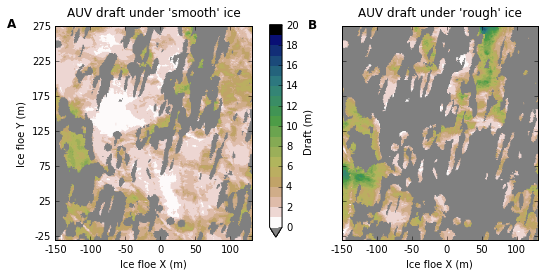

In [59]:
cmap = plt.get_cmap('gist_earth_r', 20)
cmap.set_under('gray')  # Color for values less than vmin


ytks = np.arange(-25,300,50)
ytk_l = np.arange(-25,375,50)
xtks = np.arange(-200,150,50)

fig = plt.figure(figsize = ([22/2.54, 10/2.54]), dpi=300)

ax0 = fig.add_subplot(121)
g0 = ax0.imshow(g_l_s, cmap=cmap, vmin=0, vmax=20.1)
ax0.set_title("AUV draft under 'smooth' ice", y=1.02)
ax0.set_ylabel('Ice floe Y (m)')
ax0.text(-0.22, 1.01,'A', ha='center', va='center', transform=ax0.transAxes, fontsize=12, weight='bold')
#ax0.set_yticks(ytks)
#ax0.set_yticklabels(ytks[::-1])
#ax0.set_xticks(xtks)
ax0.set_xticklabels(xtks)
ax0.set_yticklabels(ytk_l[::-1])

ax0.set_xlabel('Ice floe X (m)')



ax1 = fig.add_subplot(122)
g1 = ax1.imshow(g_l_r, cmap=cmap, vmin=0, vmax=20)
ax1.set_title("AUV draft under 'rough' ice", y=1.02)
ax1.set_xlabel('Ice floe X (m)')

cbaxes1 = fig.add_axes([0.48, 0.15, 0.02, 0.75]) 
cb1 = plt.colorbar(g1, cax=cbaxes1, cmap=cmap, extend='min')
cb1.ax.set_ylabel('Draft (m)', rotation=90)
ax1.set_yticklabels([])
ax1.set_xticklabels(xtks)
ax1.text(-0.15, 1.005,'B', ha='center', va='center', transform=ax1.transAxes, fontsize=12, weight='bold')

cmap = plt.get_cmap('BrBG', 20)

plt.tight_layout()
fig.subplots_adjust(wspace=0)

plt.savefig('draft_rough_smooth_11m.pdf', bbox_inches='tight')
plt.savefig('draft_rough_smooth_11m.png', bbox_inches='tight')

### visualising the segmented ice

/Users/arcturus/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


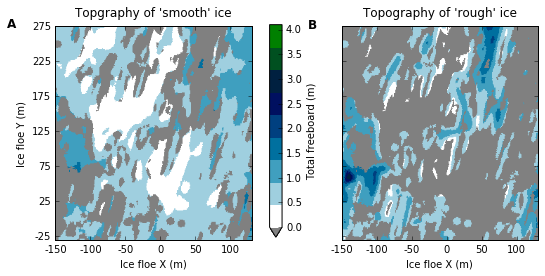

In [60]:
cmap = plt.get_cmap('ocean_r', 9)
cmap.set_under('gray')  # Color for values less than vmin

ytks = np.arange(-25,300,50)
ytk_l = np.arange(-25,375,50)
xtks = np.arange(-200,150,50)

fig = plt.figure(figsize = ([22/2.54, 10/2.54]), dpi=300)

ax0 = fig.add_subplot(121)
g0 = ax0.imshow(g_e_s, cmap=cmap, vmin=0, vmax=4.1)
ax0.set_title("Topgraphy of 'smooth' ice", y=1.02)
ax0.set_ylabel('Ice floe Y (m)')
ax0.text(-0.22, 1.01,'A', ha='center', va='center', transform=ax0.transAxes, fontsize=12, weight='bold')
#ax0.set_yticks(ytks)
#ax0.set_yticklabels(ytks[::-1])
#ax0.set_xticks(xtks)
ax0.set_xticklabels(xtks)
ax0.set_yticklabels(ytk_l[::-1])

ax0.set_xlabel('Ice floe X (m)')

ax1 = fig.add_subplot(122)
g1 = ax1.imshow(g_e_r, cmap=cmap, vmin=0, vmax=4.1)
ax1.set_title("Topography of 'rough' ice", y=1.02)
ax1.set_xlabel('Ice floe X (m)')

cbaxes1 = fig.add_axes([0.48, 0.15, 0.02, 0.75]) 
cb1 = plt.colorbar(g1, cax=cbaxes1, cmap=cmap, extend='min')
cb1.ax.set_ylabel('Total freeboard (m)', rotation=90)
ax1.set_yticklabels([])
ax1.set_xticklabels(xtks)
ax1.text(-0.15, 1.005,'B', ha='center', va='center', transform=ax1.transAxes, fontsize=12, weight='bold')

cmap = plt.get_cmap('BrBG', 20)

plt.tight_layout()
fig.subplots_adjust(wspace=0)

plt.savefig('tf_rough_smooth_11m.pdf', bbox_inches='tight')

## Summary

For this patch of ice, total freeboard and draft are strongly but not so accurately correlated. Even if we split rough and smooth ice up, we get a strong Spearman's R - and that's shown in the generally linear trend if we plot elevations and drafts together. However, the data are incredibly scattered - the vertical lines we plotted earlier show that for most elevation values, a wide range of possible drafts exist. This reflects the composite nature of sea ice! For a given elevation, there are at least two variably-thick materials with different densities.

if we look at a proxy for surface roughness and separated 'rough' and 'smooth' ice, we see that smooth regions are generally lower, but the same caveats for relating surface topography and draft exist: it's a minefield.

Rough ice on the surface generally corresponds with deeper drafts, which is convenient. 

## one more, making a 3 panel figure with all the scatterplots...

In [62]:
from statsmodels.nonparametric.smoothers_lowess import lowess

/Users/arcturus/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


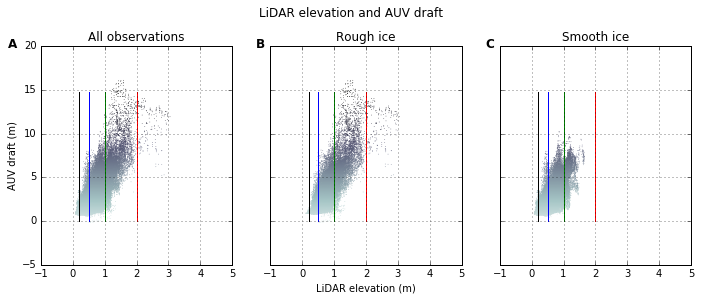

In [64]:
fig = plt.figure(figsize = ([25/2.54, 10/2.54]), dpi=300)

y_ax = np.arange(0,15,0.2)
x_ax = np.arange(0,4,0.2)
line1 = np.zeros_like(y_ax)
line1[:] = 0.2
line2 = np.ones_like(y_ax)
line2[:] = 0.5
line3 = np.ones_like(y_ax)
line3[:] = 1.0
line4 = np.ones_like(y_ax)
line4[:] = 2.0

x_lim = [-1, 5]

smth_a = lowess(g_e_1d, g_a_1d,frac=0.7)
fit = np.polyfit(g_e_1d,g_a_1d,1)
fit_fn = np.poly1d(fit)
f_s, f_i = np.polyfit(g_e_1d,g_a_1d,1)
ax0 = fig.add_subplot(131)
a0 = ax0.scatter(g_e_1d, g_a_1d, lw=0, s=0.5, c=g_a_1d, cmap='bone_r', vmin=-2, vmax=15)
#ax0.plot(x_ax, fit_fn(x_ax), 'k--', label = 'y = {:02.2f}x + {:02.2f}'.format(f_s, f_i))
#ax0.plot(smth_a[:,0], smth_a[:,1], 'k--')

ax0.set_ylabel('AUV draft (m)')
#ax0.xlabel('LiDAR elevation (m)')
ax0.plot(line1,y_ax, 'k')
ax0.plot(line2,y_ax, 'b')
ax0.plot(line3,y_ax, 'g')
ax0.plot(line4,y_ax, 'r')
ax0.grid()
#plt.axis('scaled')
ax0.set_xlim(x_lim)
ax0.set_ylim([-5, 20])
plt.legend(loc=0, fontsize=10)
ax0.set_title('All observations')
ax0.text(-0.15, 1.01,'A', ha='center', va='center', transform=ax0.transAxes, fontsize=12, weight='bold')


ax1 = fig.add_subplot(132)
rfit = np.polyfit(g_e_1d[rough],g_a_1d[rough],1)
rfit_fn = np.poly1d(rfit)
x_ax = np.arange(0,4,0.2)
smth_r = lowess(g_a_1d[rough], g_e_1d[rough],frac=0.7)
rf_s,rf_i = np.polyfit(g_e_1d[rough],g_a_1d[rough],1)
a1 = ax1.scatter(g_e_1d[rough], g_a_1d[rough], lw=0, s=0.5, c=g_a_1d[rough], cmap='bone_r', vmin=-2, vmax=15)
#ax1.plot(x_ax, rfit_fn(x_ax), 'k--', label = 'y = {:02.2f}x + {:02.2f}'.format(rf_s, rf_i) )
#ax1.plot(smth_r[:,0], smth_r[:,1], 'k--')
#ax1.ylabel('AUV draft (m)')
ax1.set_xlabel('LiDAR elevation (m)')
ax1.plot(line1,y_ax, 'k')
ax1.plot(line2,y_ax, 'b')
ax1.plot(line3,y_ax, 'g')
ax1.plot(line4,y_ax, 'r')
ax1.set_title('Rough ice')
ax1.grid()
#plt.axis('scaled')
ax1.set_xlim(x_lim)
ax1.set_ylim([-5, 20])
ax1.set_yticklabels([])
plt.legend(loc=0, fontsize=10)
ax1.text(-0.05, 1.01,'B', ha='center', va='center', transform=ax1.transAxes, fontsize=12, weight='bold')


ax2 = fig.add_subplot(133)
sfit = np.polyfit(g_e_1d[smooth],g_a_1d[smooth],1)
sfit_fn = np.poly1d(fit)
smth_r = lowess(g_a_1d[rough], g_e_1d[rough],frac=0.7)
sf_s,sf_i = np.polyfit(g_e_1d[smooth],g_a_1d[smooth],1)
a2 = ax2.scatter(g_e_1d[smooth], g_a_1d[smooth], lw=0, s=0.5, c=g_a_1d[smooth], cmap='bone_r', vmin=-2, vmax=15)
#ax2.plot(x_ax, sfit_fn(x_ax), 'k--', label = 'y = {:02.2f}x + {:02.2f}'.format(sf_s, sf_i) )
#ax2.plot(smth_r[:,0], smth_r[:,1], 'k--')

ax2.plot(line1,y_ax, 'k')
ax2.plot(line2,y_ax, 'b')
ax2.plot(line3,y_ax, 'g')
ax2.plot(line4,y_ax, 'r')
ax2.set_title('Smooth ice')
ax2.grid()
#plt.axis('scaled')
ax2.set_xlim(x_lim)
ax2.set_ylim([-5, 20])
ax2.set_yticklabels([])
plt.legend(loc=0, fontsize=10)
ax2.text(-0.05, 1.01,'C', ha='center', va='center', transform=ax2.transAxes, fontsize=12, weight='bold')


plt.suptitle("LiDAR elevation and AUV draft", y=1.05, fontsize=12)

plt.tight_layout()
fig.subplots_adjust(wspace=0.2)


plt.savefig('elev_draft_rough_smooth_11m.pdf', bbox_inches='tight')
plt.savefig('elev_draft_rough_smooth_11m.png', bbox_inches='tight')




### Conclusions

It is quite clear that a single ratio of total freeboard to ice draft is not a great way to determine sea ice thickness from altimetry.

Rougher ice has a higher mean total freeboard, but clearly (and predictably) more variablity. Interestingly, rough ice is found for all values of total freeboard - whereas 'smooth' ice is capped at total freeboard of around 2 m. Which is still quite a lot! This is a pretty crude segmentation - better feature finders will come along!

Neatly, deepest drafts occur under 'rough' ice.